In [11]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from torch import nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [50]:

class BetterNN(nn.Module):
    """
    This is a better neural network model ready to use feature vector
    """
    def __init__(self, input_size=38, output_size=18):
        super(BetterNN, self).__init__()
        
        # use relu as activation function, cause any other is not suitable for this task
        self.activation = nn.ReLU()
        
        # Conv1d layer
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3)
        
        # Calculate the size after the Conv1d layer
        # Assuming input_size is the length of the sequence and the input is of shape (batch_size, 1, input_size)
        conv_output_size = (input_size - 3 + 1)  # since kernel_size=3 and stride=1, padding=0
        
        # First linear layer should take conv_output_size as input
        self.fc1 = nn.Linear(conv_output_size, 200)
        
        # the hidden part of linear layers
        self.fc2 = nn.Linear(200, 500)  # Change input size according to fc1 output
        self.fc3 = nn.Linear(500, 500)
        self.fc4 = nn.Linear(500, 300)
        self.fc5 = nn.Linear(300, 100)
        
        # The output layer for classification
        self.fc6 = nn.Linear(100, output_size)

    def forward(self, x):
        # Reshape x to fit Conv1d input requirements
        x = x.unsqueeze(0)  # Add a channel dimension: (batch_size, 1, input_size)
        x = self.conv1d(x)  # Apply Conv1d
        x = x.squeeze(1)     # Remove the channel dimension after conv: (batch_size, conv_output_size)
        
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x)
        x = self.fc6(x)
        return x
    
model = BetterNN().to(device)
test_input = torch.randn(38).to(device)
# print(model(test_input.unsqueeze(0)))
# print(model(test_input.unsqueeze(0)))
# print(test_input)
res = model(test_input)
# print(res)

tensor([[ 0.4034, -1.0692, -0.4050,  0.3206, -0.1947,  0.1601,  0.2184, -1.1220,
          0.2959, -0.7759,  0.1486, -0.0428,  0.2201, -0.5991,  0.3525, -0.5592,
         -0.2853, -0.1785,  0.2521, -0.7778, -0.1933, -0.1364,  0.7286, -1.5123,
          0.3315,  0.3075, -0.1721, -0.6392,  0.3237, -1.2003,  0.4557, -0.4208,
         -0.1543, -0.2181,  0.4609, -0.2823]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([[ 0.2688, -0.0372,  0.1033, -0.0051,  0.4012, -0.1902, -0.2765,  0.1122,
          0.6812,  0.1667,  0.0921, -0.0554,  0.3195,  0.0292, -0.0074,  0.2916,
          0.7115,  0.2721, -0.3075,  0.2344, -0.0287, -0.0670, -0.1390, -0.0542,
         -0.0900, -0.0484,  0.1729,  0.1270,  0.2835,  0.2054, -0.5852, -0.1353,
          0.4351,  0.3613,  0.3615, -0.4661, -0.2640,  0.3290,  0.8780,  0.5345,
          0.1797, -0.1702,  0.1878, -0.2616,  0.3814, -0.2181, -0.2517, -0.3227,
         -0.1456,  0.3298, -0.0966,  0.2838, -0.5331, -0.3012, -0.0604,  0.7774,
          

In [45]:
print(model(test_input))

tensor([[-0.0116, -0.0193,  0.0584, -0.0119,  0.0581, -0.0584,  0.0703,  0.0130,
         -0.0215, -0.1100, -0.0601,  0.0084, -0.0253,  0.0212,  0.0143, -0.0261,
          0.0766, -0.0783]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [6]:
class ATCDataset_v2(Dataset):
    
    def __init__(self, in_data_path, out_data_path):
        """
        Args:
            data_path (str): path to the data in csv format
        """
        self.df = pd.read_csv(
            in_data_path,
            delimiter=",",
            header=0
            )
        self.out_df = pd.read_csv(
            out_data_path,
            delimiter=",",
            header=0
            )
        
        # build OUTPUT DATA for the loss function
        # ========================================
        # labels for vector of the ouput boxes 
        labels = [
            "OM0000", "OM0001", "OM0002", "OM0003", "OM0004", "OM0005", "OM0006", "OM0007", 
            "OM0008", "OM0009", "OM0010", "PAL01", "PAL02", "PAL03", "PAL04", "PAL05", "PAL06", 
            "PAL07"
        ]

        # result vector contains number of occurences of each box for each group of items
        result_vector = {}
        for group in self.out_df['GroupDelivery'].unique():
            result_vector[group] = np.zeros((labels.__len__()))
            
        for _, row in self.out_df.iterrows():
            cartonName = row['UsedCarton'].strip().upper()
            result_vector[row['GroupDelivery']][labels.index(cartonName)] += 1
        self.result_vector = result_vector
        
        # build INPUT DATA 
        # ========================================
        
        # Apply the function to each GroupDelivery
        def vectorize(group):
            return group[['X', 'Y', 'Z', 'Weight', 'Qty']].values.flatten().tolist()
        
        grouped = self.df.groupby('GroupDelivery').apply(vectorize, include_groups=False).reset_index()

        
        # Rename columns
        grouped.columns = ['GroupDelivery', 'Vector']
        
        # store vectors and group delivery
        self.vectors = grouped.Vector
        self.groupDelivery = grouped.GroupDelivery

In [7]:
TEST_IN="data/test_in.csv"
TEST_OUT="data/test_out.csv"

data_test = ATCDataset_v2(TEST_IN, TEST_OUT)

In [8]:
data_test.df

,GroupDelivery,Product,X,Y,Z,Weight,Qty
0,12012132,734634,9.0,6.4,18.8,0.660,2
1,12012132,734372,9.3,6.7,19.4,0.664,1
2,12012133,734372,9.3,6.7,19.4,0.664,2
3,12012133,734634,9.0,6.4,18.8,0.660,1
4,12012134,734634,9.0,6.4,18.8,0.660,1
...,...,...,...,...,...,...,...
133930,12049505,691595,8.0,3.1,16.5,0.276,2
133931,12049506,709274,18.5,2.1,11.2,0.082,1
133932,12049508,519998,24.7,1.7,16.0,0.088,1
133933,12049509,305990,15.0,5.3,11.5,0.120,1


In [108]:
# this is create feature vector function
# it creates from the group of items a single vector, that describes most the group
def create_feature_vector(group):
    gr = group[['X','Y','Z','Weight']].copy()
    gr_all = group[['X','Y','Z','Weight','Qty']].copy()
    
    # get the sum of the values
    x_sum,y_sum,z_sum,w_sum = gr.sum(numeric_only=True, axis=0)
    # get the mean of the values
    x_mean, y_mean, z_mean, w_mean = gr.mean(numeric_only=True, axis=0)
    # get the standard deviation of the values
    x_std, y_std, z_std, w_std = gr.std(numeric_only=True, axis=0)
    # get the median of the values
    x_median, y_median, z_median, w_median = gr.median(numeric_only=True, axis=0)
    # get qty of items to boxes according to the weight
    bins_weight = [0, 1, 3, 6, 9, 13, 20, 25, 30, 100]  # Example weight ranges for bins
    labels_weight = ['0-1kg', '1-3kg', '3-6kg', '6-9kg','9-13kg','13-20kg','20-25kg','25-30kg','30-nkg']  # Labels for bins
    gr_all.loc[:,'Weight_bin'] = pd.cut(gr['Weight'], bins=bins_weight, labels=labels_weight, right=False)
    # get qty of items to boxes according to the volume
    gr.loc[:,'Volume'] = gr['X']*gr['Y']*gr['Z']
    
    bins_volume = [0,1000,2000,5000,10000,30000,50000,80000,100000,150000,250000,400000,600000,800000,1000000,10000000] # cm3
    labels_volume = [ 
        '0-1dm3','1-2dm3','2-5dm3','5-10dm3', '10-30dm3', '30-50dm3', '50-80dm3', '80-100dm3', 
        '100-150dm3', '150-250dm3', '250-400dm3', '400-600dm3', 
        '600-800dm3', '800-1000dm3', '1000-10000dm3'
    ]  # Labels for bins (written in dm3 for better readability)
    gr_all.loc[:,'Volume_bin'] = pd.cut(gr['Volume'], bins=bins_volume, labels=labels_volume, right=False)

    # return the values as a pandas series
    feature_vector = pd.Series(
        [
            x_sum, y_sum, z_sum, w_sum,
            x_mean, y_mean, z_mean, w_mean,
            x_std, y_std, z_std, w_std,
            x_median, y_median, z_median, w_median
        ], 
        index=[
            'X_sum', 'Y_sum', 'Z_sum', 'Weight_sum',
            'X_mean', 'Y_mean', 'Z_mean', 'Weight_mean',
            'X_std', 'Y_std', 'Z_std', 'Weight_std',
            'X_median', 'Y_median', 'Z_median', 'Weight_median'
        ])
    
    # Get the counts of each weight bin
    weight_bin_qty_sum = gr_all.groupby('Weight_bin',observed=True)['Qty'].sum()
    volume_bin_qty_sum = gr_all.groupby('Volume_bin',observed=True)['Qty'].sum()
    # Append the weight bin counts to the feature vector
    for bin_label in labels_weight:
        feature_vector[f'bin_{bin_label}_count'] = weight_bin_qty_sum.get(bin_label, 0)
    for bin_label in labels_volume:
        feature_vector[f'bin_{bin_label}_count'] = volume_bin_qty_sum.get(bin_label, 0)
    return feature_vector.fillna(0)

In [94]:
d = data_test.df.groupby('GroupDelivery',observed=True).apply(func=create_feature_vector, include_groups=False).reset_index()
d

,GroupDelivery,X_sum,Y_sum,Z_sum,Weight_sum,X_mean,Y_mean,Z_mean,Weight_mean,X_std,...,bin_30-50dm3_count,bin_50-80dm3_count,bin_80-100dm3_count,bin_100-150dm3_count,bin_150-250dm3_count,bin_250-400dm3_count,bin_400-600dm3_count,bin_600-800dm3_count,bin_800-1000dm3_count,bin_1000-10000dm3_count
0,12012132,18.3,13.1,38.2,1.324,9.150000,6.550000,19.10,0.662000,0.212132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12012133,18.3,13.1,38.2,1.324,9.150000,6.550000,19.10,0.662000,0.212132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12012134,18.3,13.1,38.2,1.324,9.150000,6.550000,19.10,0.662000,0.212132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12012135,47.9,16.9,62.4,1.580,15.966667,5.633333,20.80,0.526667,7.637626,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12012136,18.3,13.1,38.2,1.324,9.150000,6.550000,19.10,0.662000,0.212132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30132,12049504,15.2,3.5,16.1,0.078,15.200000,3.500000,16.10,0.078000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30133,12049505,8.0,3.1,16.5,0.276,8.000000,3.100000,16.50,0.276000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30134,12049506,18.5,2.1,11.2,0.082,18.500000,2.100000,11.20,0.082000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30135,12049508,24.7,1.7,16.0,0.088,24.700000,1.700000,16.00,0.088000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
one = data_test.df.groupby('GroupDelivery').get_group(12022211)
res = create_feature_vector(one) 
res

X_sum                      9.900
Y_sum                      4.700
Z_sum                      9.800
Weight_sum                 0.248
X_mean                     9.900
Y_mean                     4.700
Z_mean                     9.800
Weight_mean                0.248
X_std                      0.000
Y_std                      0.000
Z_std                      0.000
Weight_std                 0.000
X_median                   9.900
Y_median                   4.700
Z_median                   9.800
Weight_median              0.248
bin_0-1kg_count            1.000
bin_1-3kg_count            0.000
bin_3-6kg_count            0.000
bin_6-9kg_count            0.000
bin_9-13kg_count           0.000
bin_13-20kg_count          0.000
bin_20-25kg_count          0.000
bin_25-30kg_count          0.000
bin_30-nkg_count           0.000
bin_0-1dm3_count           1.000
bin_1-2dm3_count           0.000
bin_2-5dm3_count           0.000
bin_5-10dm3_count          0.000
bin_10-30dm3_count         0.000
bin_30-50d

In [66]:
x = np.arange(start=0, stop=data_test.df.shape[0], step=1)
y = np.array([0]*data_test.df.shape[0])
for i,s in data_test.df.iterrows():
    y[i] = s.X*s.Y*s.Z
    if (y[i] > 3000000):
        print(s)
        print(i)
        print(y[i])
        break

GroupDelivery    12021210.0
Product            416646.0
X                     310.0
Y                     162.0
Z                     110.0
Weight                445.0
Qty                     1.0
Name: 34927, dtype: float64
34927
5524200


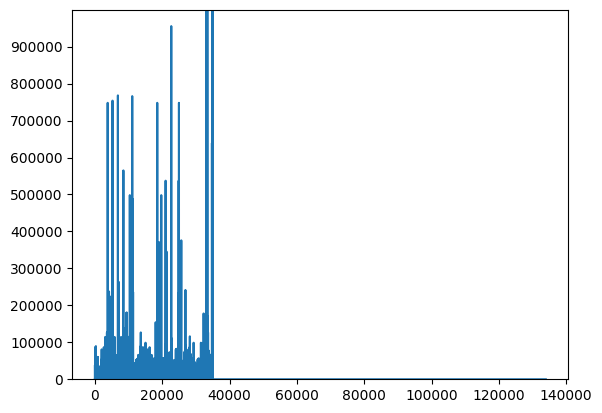

In [69]:
import matplotlib.pyplot as plt
ax = plt.plot(x, y)
plt.ylim(0, 1000000)
plt.yticks(np.arange(0, 1000000, step=100000))
bins_volume = [0,10000,30000,50000,80000,100000,150000,250000,400000,600000,800000,1000000,10000000]

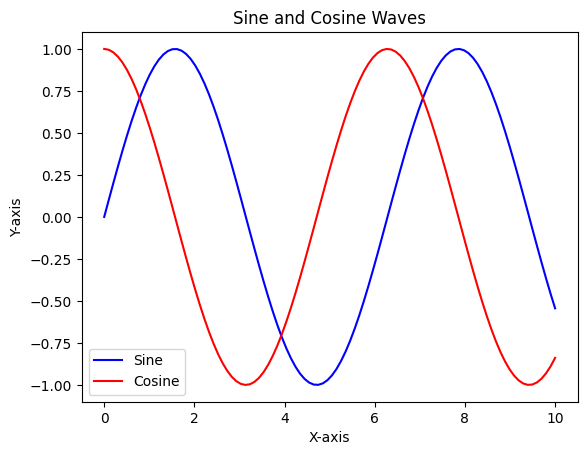

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# Create the plot
plt.figure()

# Plot the first graph (sine)
plt.plot(x, y1, label='Sine', color='b')

# Plot the second graph (cosine)
plt.plot(x, y2, label='Cosine', color='r')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Sine and Cosine Waves')

# Add a legend to differentiate the two graphs
plt.legend()

# Show the plot
plt.show()